## LSTM Model for parsed at sentence level text (Melisa)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/dataminingproje/source')
import utils
import models as md

In [32]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D, BatchNormalization,Conv1D, GlobalMaxPooling1D
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

np.random.seed(11)

# **Prepare Dataset**


In [5]:
#please download test.json and train_preprocessed.json and glove.6b.200d.txt files from our google drive, since they
#were too big to put to github or send through ninova. input them into the data folder and this path should work.
"""
train_path = "../../data/train_preprocessed.json"
test_path = "../../data/test.json"
embeddings_path = "../../data/glove.6B.200d.txt"
lstm_model_path =  "../pretrained_models/lstm_model"
"""

train_path = "/content/drive/MyDrive/dataminingproje/data/train_preprocessed.json"
test_path = "/content/drive/MyDrive/dataminingproje/data/test.json"
embeddings_path = "/content/drive/MyDrive/dataminingproje/data/glove.6B.200d.txt"
lstm_model_path =  "/content/drive/MyDrive/dataminingproje/data/trained_model_lstm2"

max_words = 5000
embedding_dim = 200

train, train_l, test, test_l, tokenizer, max_seq_length = utils.read_dataset(train_path, test_path, max_words, balance_train = True, balance_test = True, only_lstm = True)
print("Prepared Data")
embedding_matrix = utils.embeddings(embeddings_path, embedding_dim, tokenizer, max_words)
print("Prepared embeddings matrix")

Prepared Data
Prepared embeddings matrix


# **Working With Pretrained Model**


In [8]:
#loading in pretrained model.

lstm_model = md.LSTM_model(max_words, embedding_dim, embedding_matrix, max_seq_length)
lstm_model.load_weights(lstm_model_path)

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [39]:
#evaluate model on test set
test_loss, test_accuracy, test_precision, test_recall = lstm_model.evaluate(test, test_l, verbose=0)

In [50]:
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1: {2*test_recall*test_precision / (test_recall+test_precision)}")

Test Accuracy: 0.772287130355835
Test Precision: 0.6983545422554016
Test Recall: 0.7449793219566345
Test F1: 0.7209138596062693


In [10]:
predictions = lstm_model.predict(test)

1033/1033 [==============================] - 120s 115ms/step
[0.720400958265036, 0.727185134205093, 0.7209138448985647, 0.7007594118597511, 0.643155031731641]


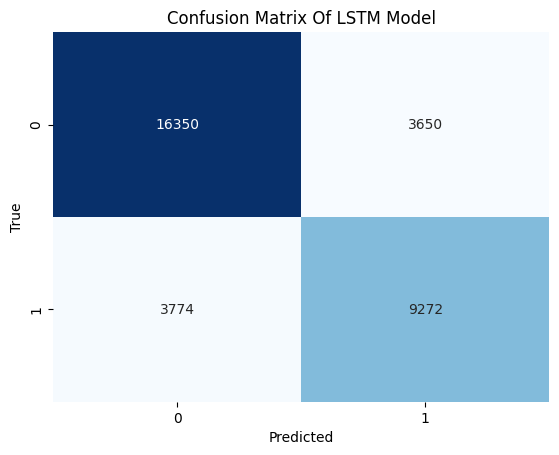

In [52]:
#plot confusion matrix
y_pred = (predictions > 0.55).astype(int)
cm = confusion_matrix(test_l, y_pred)
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix Of LSTM Model')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()




We get an AUC score of: 0.8531954794573049


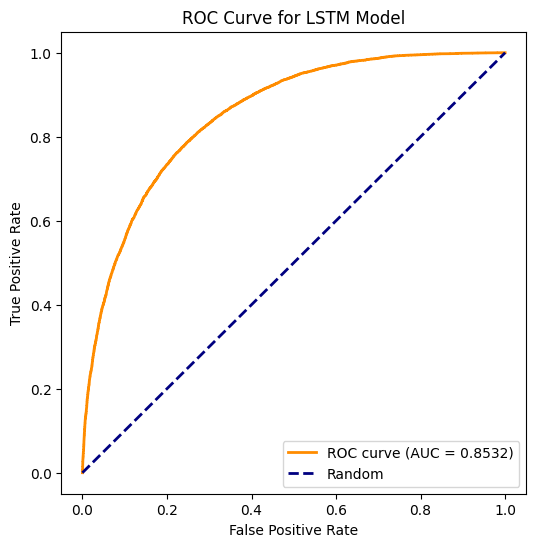

In [54]:
#calculate auc score
auc_score = roc_auc_score(test_l, predictions)
print(f"We get an AUC score of: {auc_score}")

fpr, tpr, thresholds = roc_curve(test_l, predictions.ravel())
roc_auc = auc(fpr, tpr)

#plotting roc curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LSTM Model')
plt.legend(loc='lower right')
plt.show()

# **Train LSTM Model from Scratch**

In [6]:
#load in model from model.py
model = md.LSTM_model(max_words, embedding_dim, embedding_matrix, max_seq_length)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2596, 200)         1000000   
                                                                 
 bidirectional (Bidirection  (None, 2596, 256)         336896    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 2596, 256)         1024      
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 2596, 64)          82176     
                                                                 
 lstm_2 (LSTM)               (None, 16)                5184      
                                                                 
 batch_normalization_1 (Bat  (None, 16)                6

In [55]:
#to solve vanishing gradient problem, add clipvalue to optimizer.
optimizer = Adam(clipvalue=1.0)
#using a learning rate scheduler to further optimize the model
lr_scheduler = LearningRateScheduler(utils.lr_schedule)

num_epochs = 5
batch_size = 256

In [ ]:
#the dataset is not fully balanced, thus use class weights to give varying importance to the classes.
class_weights = compute_class_weight('balanced', classes=pd.unique(train_l), y=train_l)
class_weight_dict = dict(enumerate(class_weights))

train_l = train_l.values

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
num_folds = 5

#use stratifiedKFold since the data is unbalanced.
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=11)

for fold, (train_index, val_index) in enumerate(kf.split(train, train_l)):
    print(f"Fold {fold + 1}:")

    #splitting data into training and validation sets
    X_train_fold, X_val_fold = train[train_index], train[val_index]
    y_train_fold, y_val_fold = train_l[train_index], train_l[val_index]

    #training the model on the training set
    model.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, class_weight=class_weight_dict,
              validation_data=(X_val_fold, y_val_fold), callbacks=[lr_scheduler])

    #evaluating the model on the validation set
    y_val_pred = model.predict(X_val_fold)
    y_val_pred_binary = (y_val_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_val_fold, y_val_pred_binary)
    precision = precision_score(y_val_fold, y_val_pred_binary)
    recall = recall_score(y_val_fold, y_val_pred_binary)
    print(f"Validation Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")



#evaluating on test set
test_results = model.evaluate(test, test_l)
print(f"Test Loss: {test_results[0]}, Test Accuracy: {test_results[1]}")

In [ ]:
#save the model weights to desired path
save_path = "/content/drive/MyDrive/dataminingproje/data/trained_model_lstm4"
model.save_weights(save_path, save_format="h5")
